In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
import sklearn
from sklearn import decomposition
from sklearn.datasets import load_iris

In [2]:
print('Numpy version {}.'.format(np.__version__))
print('Sklearn version {}.'.format(sklearn.__version__))

Numpy version 1.13.3.
Sklearn version 0.19.1.


---

### Covariance Function (for explanatory purposes only)

In [3]:
def covariance_matrix(matrix):
    '''returns the covariance matrix'''
    import numpy as np
    
    # setup
    n_rows = len(matrix)
    divisor = n_rows - 1
    col_means = np.mean(matrix, axis=0, keepdims=True)
    
    # main logic
    centered_matrix = matrix - col_means
    covariance_matrix = np.dot(centered_matrix.T, centered_matrix) / divisor
    
    return covariance_matrix

---

### Generate Data

In [4]:
matrix = np.random.randint(1, 10, (4,4))
matrix

array([[2, 6, 3, 4],
       [6, 1, 2, 9],
       [5, 8, 1, 2],
       [4, 9, 7, 9]])

---

### Numpy Covariance Matrix

In [5]:
np.cov(matrix, rowvar=False)

array([[  2.91666667,  -2.66666667,  -1.41666667,   2.        ],
       [ -2.66666667,  12.66666667,   4.33333333,  -4.66666667],
       [ -1.41666667,   4.33333333,   6.91666667,   5.66666667],
       [  2.        ,  -4.66666667,   5.66666667,  12.66666667]])

### My Covariance Matrix

In [6]:
covariance_matrix(matrix)

array([[  2.91666667,  -2.66666667,  -1.41666667,   2.        ],
       [ -2.66666667,  12.66666667,   4.33333333,  -4.66666667],
       [ -1.41666667,   4.33333333,   6.91666667,   5.66666667],
       [  2.        ,  -4.66666667,   5.66666667,  12.66666667]])

---

# The PCA Algorithm

PCA requires the following sequential steps:

1) calculate covariance matrix  
2) calculate eigenvalues and eigenvectors  
3) sort eigenvectors and eigenvalues in descending order  
4) transform original dataset using sorted eigenvectors

---

In [7]:
class PCA:
    
    import numpy as np
    
    def __init__(self, n_components):
        self.n_components_ = n_components
        self.explained_variance_ = None
        
    def _covariance_matrix(self, matrix):
        '''returns the covariance matrix'''
        n_rows = len(matrix)
        divisor = matrix.shape[0] - 1
        centered_matrix = matrix - np.mean(matrix, axis=0, keepdims=True)
        return np.dot(centered_matrix.T, centered_matrix) / divisor
    
    def _eigendecomposition(self, cov_matrix):
        '''return eigenvalues and eigenvectors of covariance matrix'''
        eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
        return eigenvals, eigenvecs
    
    def _eigensort(self, eigenvalues, eigenvectors):
        '''return eigenvalues and associated eigenvectors sorted in descending order'''
        sorted_eigval_indices = np.argsort(-eigenvalues)
        sorted_eigenvalues = eigenvalues[sorted_eigval_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_eigval_indices]
        return sorted_eigenvalues, sorted_eigenvectors
    
    def fit(self, matrix):
        ''''''
        cov_matrix = self._covariance_matrix(matrix)
        eigenvals, eigenvecs = self._eigendecomposition(cov_matrix)
        self._sorted_eigenvalues, self._sorted_eigenvectors = self._eigensort(eigenvals, eigenvecs)
        self.explained_variance_ = self._sorted_eigenvalues / np.sum(self._sorted_eigenvalues)
        # subset to n_components
        self._sorted_eigenvalues = self._sorted_eigenvalues[:self.n_components_]
        self._sorted_eigenvectors = self._sorted_eigenvectors[:, :self.n_components_]
        self.explained_variance_ = self.explained_variance_[:self.n_components_]
    
    def transform(self, matrix):
        '''transform data matrix into PCA space'''
        demeaned_matrix = matrix - np.mean(matrix, axis=0, keepdims=True)
        return np.dot(demeaned_matrix, self._sorted_eigenvectors)

---

## Comparison: Sklearn vs My Implementation

### Sklearn PCA

In [8]:
spca = decomposition.PCA(n_components=3, random_state=42)
spca.fit(matrix)
sklearn_transform = spca.transform(matrix)

In [9]:
spca.components_

array([[ 0.2014346 , -0.65029593,  0.09077023,  0.72684254],
       [-0.13145347,  0.56492928,  0.67385022,  0.45771254],
       [-0.89868317, -0.37027599,  0.20866112, -0.10828109]])

In [10]:
spca.explained_variance_ratio_

array([ 0.51480033,  0.41729868,  0.06790099])

In [11]:
sklearn_transform

array([[-1.92960548, -0.78811734,  2.18643403],
       [ 5.671055  , -2.52386513, -0.30698528],
       [-4.26111908, -2.3157447 , -1.45092752],
       [ 0.51966956,  5.62772717, -0.42852123]])

### My Implementation

In [12]:
pca = PCA(n_components=3)
pca.fit(matrix)

In [13]:
pca._sorted_eigenvectors.T

array([[ 0.2014346 , -0.65029593,  0.09077023,  0.72684254],
       [-0.13145347,  0.56492928,  0.67385022,  0.45771254],
       [ 0.89868317,  0.37027599, -0.20866112,  0.10828109]])

In [14]:
pca.explained_variance_

array([ 0.51480033,  0.41729868,  0.06790099])

In [15]:
pca.transform(matrix)

array([[-1.92960548, -0.78811734, -2.18643403],
       [ 5.671055  , -2.52386513,  0.30698528],
       [-4.26111908, -2.3157447 ,  1.45092752],
       [ 0.51966956,  5.62772717,  0.42852123]])

## Are Eigenvectors Equivalent?
I'm taking the absolute value of the eigenvectors because which direction a vector points makes no difference in this case. The only thing that matters is the orientation of the principal components.

In [16]:
np.allclose(abs(spca.components_), abs(pca._sorted_eigenvectors.T))

True

---

## Example: Iris Dataset

In [17]:
iris = load_iris()
data = iris.data
target = iris.target

#### Sklearn

In [18]:
sklearn_pca = decomposition.PCA(n_components=4, random_state=42)
sklearn_pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
sklearn_pca.explained_variance_ratio_

array([ 0.92461621,  0.05301557,  0.01718514,  0.00518309])

In [20]:
sklearn_pca.components_

array([[ 0.36158968, -0.08226889,  0.85657211,  0.35884393],
       [ 0.65653988,  0.72971237, -0.1757674 , -0.07470647],
       [-0.58099728,  0.59641809,  0.07252408,  0.54906091],
       [ 0.31725455, -0.32409435, -0.47971899,  0.75112056]])

#### My Implementation

In [21]:
my_pca = PCA(n_components=4)
my_pca.fit(data)

In [22]:
my_pca.explained_variance_

array([ 0.92461621,  0.05301557,  0.01718514,  0.00518309])

In [23]:
my_pca._sorted_eigenvectors.T

array([[-0.36158968,  0.08226889, -0.85657211, -0.35884393],
       [ 0.65653988,  0.72971237, -0.1757674 , -0.07470647],
       [ 0.58099728, -0.59641809, -0.07252408, -0.54906091],
       [ 0.31725455, -0.32409435, -0.47971899,  0.75112056]])

### Explained Variance Plot

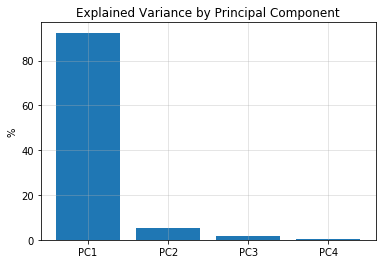

In [24]:
plt.bar(['PC1', 'PC2', 'PC3', 'PC4'], my_pca.explained_variance_ * 100)
plt.title('Explained Variance by Principal Component')
plt.ylabel('%')
plt.grid(alpha=0.4);